
Based on NLP From Scratch: Generating Names with a Character-Level RNN
*************************************************************
by: `Sean Robertson <https://github.com/spro/practical-pytorch>`_


In [2]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os
import unicodedata
import string
import random
from random import shuffle
import torch
import torch.nn as nn
from functools import reduce
from collections import Counter
import re
import numpy as np
%matplotlib inline

In [3]:


class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1, bias=True, batch_first=False,
                dropout=0, bidirectional=False):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        if bidirectional:
            self.num_directions = 2
        else:
            self.num_directions = 1
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, 
                            num_layers=num_layers, bias=bias, batch_first=batch_first,
                           dropout=dropout, bidirectional=bidirectional)
#         self.i2h = nn.Linear(n_categories + input_size + hidden_size, hidden_size)
#         self.i2o = nn.Linear(n_categories + input_size + hidden_size, output_size)

        self.o2o = nn.Linear(self.num_directions * hidden_size, output_size)
#         self.dropout = nn.Dropout(0.1)
#         self.softmax = nn.Softmax(dim=2)

    def forward(self, my_input, hidden):
#         input_combined = torch.cat((category, input, hidden), 1)
#         hidden = self.i2h(input_combined)
#         output = self.i2o(input_combined)
#         output_combined = torch.cat((hidden, output), 1)
#         output = self.o2o(output_combined)
#         output = self.dropout(output)
        output, hidden = self.lstm(my_input, hidden)
        output = self.o2o(output)
#         output = self.softmax(output)
        return output, hidden

    def initHidden(self, batch=1, device=torch.device('cpu')):
        return (torch.zeros(self.num_layers,1,self.hidden_size, device=device), torch.zeros(self.num_layers * self.num_directions,batch,self.hidden_size,device=device))
#         return torch.zeros(1, self.hidden_size)

In [4]:

def string_to_chars(original):
    raw_lines = original.splitlines()

    def proc_line(l): return [l] if l == '<start>' or l == '<end>' else list(l)
    chars = reduce(lambda x, y : x + ['\n'] + y, list(map(proc_line, raw_lines)))
    assert original == ''.join(chars)
    return chars

def make_encoder(raw):
    chars = string_to_chars(raw)
    decoder = [c for c in Counter(chars)]
    decoder = sorted(decoder)
    return {c:i for i, c in enumerate(decoder)}, decoder

def split_songs(raw):
    return re.findall('(<start>.*?<end>)',raw,flags=re.DOTALL)

# train_songs = list(map(string_to_chars, split_songs(raw_train)))

# reconstructed = '\n'.join(map(''.join, train_songs))
# encoder, decoder = make_encoder(raw_train)
# n_chars = len(decoder)

def song_to_tensor_chunks(song,encoder, decoder):
    training_chunks = []
    target_chunks = []
    for i in range(0,len(song),100):
        start = i
        if start+100 > len(song) - 1:
            end = len(song)
            target_range = list(np.arange(start + 1, end,dtype=np.int)) + [int(end - 1)]
        else:
            end = start + 100
            target_range = np.arange(start+1, end+1, dtype=np.int)
        chunk = torch.zeros(end-start, 1, n_chars)
        for i, c in enumerate(song[start:end]):
            chunk[i,0,encoder[c]] = 1
        target_chunk = []
        for i in target_range:
            target_chunk.append(encoder[song[i]])
        target_chunks.append(torch.tensor(target_chunk))
        training_chunks.append(chunk)
    return training_chunks, target_chunks


In [5]:
raw_train = open('train.txt').read()
train_songs = list(map(string_to_chars, split_songs(raw_train)))

reconstructed = '\n'.join(map(''.join, train_songs))
encoder, decoder = make_encoder(raw_train)
n_chars = len(decoder)
val_songs = list(map(string_to_chars, split_songs(open('val.txt').read())))
test_songs = list(map(string_to_chars, split_songs(open('test.txt').read())))
assert reconstructed == raw_train


For convenience during training we'll make a ``randomTrainingExample``
function that fetches a random (category, line) pair and turns them into
the required (category, input, target) tensors.




Training the Network
--------------------

In contrast to classification, where only the last output is used, we
are making a prediction at every step, so we are calculating loss at
every step.

The magic of autograd allows you to simply sum these losses at each step
and call backward at the end.




In [6]:
criterion = nn.CrossEntropyLoss()

def train(song,optimizer=None, device=torch.device('cpu')):
    train_chunks, target_chunks = song_to_tensor_chunks(song, encoder,decoder)
    hidden = rnn.initHidden(device=device)
    rnn.zero_grad()

    loss = 0

    for input_line_tensor, target_line_tensor in zip(train_chunks,target_chunks):
        target_line_tensor.unsqueeze_(-1)
        for i in range(input_line_tensor.size(0)):
            output, hidden = rnn(input_line_tensor[i].view((1,1,n_chars)).to(device), hidden)
    #         print(output)
            l = criterion(output.view((1,n_chars)), target_line_tensor[i].to(device))
            loss += l / input_line_tensor.size(0)

    loss.backward()
    optimizer.step()

    return output, loss.item() / len(train_chunks)
def test(rnn, song, device=torch.device('cpu')):
    train_chunks, target_chunks = song_to_tensor_chunks(song, encoder,decoder)
    hidden = rnn.initHidden(device=device)
    loss = 0
    for input_line_tensor, target_line_tensor in zip(train_chunks,target_chunks):
        target_line_tensor.unsqueeze_(-1)
        output, hidden = rnn(input_line_tensor.to(device), hidden)
        seq_len,_ =target_line_tensor.size()
        l = criterion(output.view((seq_len,n_chars)), target_line_tensor.view((seq_len)).to(device))
        loss += l
    return output, loss.item() / len(train_chunks)

In [7]:
import time
import math

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [8]:
# Check if your system supports CUDA
use_cuda = torch.cuda.is_available()

# Setup GPU optimization if CUDA is supported
if use_cuda:
    device = torch.device("cuda")
    extras = {"num_workers": 1, "pin_memory": True}
    print("CUDA is supported")
else: # Otherwise, train on the CPU
    device = torch.device("cpu")
    extras = False
    print("CUDA NOT supported")

CUDA is supported


In [9]:
rnn = RNN(n_chars, 64, n_chars).to(device) #hidden_size originally 128
rnn.load_state_dict(torch.load('rnn_1574760411.pt'))
rnn = rnn.to(device)
train_loss = list(map(float,(open('train_loss_1574760411.csv').read().splitlines())))
val_loss = list(map(float,(open('val_loss_1574760411.csv').read().splitlines())))
#print(len(train_loss))
#start = len(train_loss)

optimizer = torch.optim.Adam(rnn.parameters())

In [10]:
# rnn = RNN(n_chars, 128, n_chars).to(device)
learning_rate = 0.05
# optimizer = torch.optim.Adam(rnn.parameters())
n_iters = 10000
print_every = 80
plot_every = 10
# train_loss = []
# val_loss = []
total_loss = 0 # Reset every plot_every iters
n_epochs = 1
start = time.time()

for epoch in range(int(start),int(start+n_epochs)):
    shuffle(train_songs)
    total_loss = 0
    for i, song in enumerate(train_songs):
        output, loss = train(song,optimizer=optimizer, device=device)
        total_loss += loss
        if i % print_every == 0:
            print('%s (%d %d%%) %.4f' % (timeSince(start), i, i / len(train_songs) * 100, loss))


    train_loss.append(total_loss / len(train_songs))
    with torch.no_grad():
        total_loss = 0
        for song in test_songs:
            _, loss = test(rnn, song, device=device)
            total_loss += loss
        val_loss.append(total_loss / len(test_songs))
    torch.save(rnn.state_dict(),f'rnn_{epoch}.pt')
    with open(f'train_loss_{epoch}.csv', 'w+') as out:
        out.write('\n'.join(map(str,train_loss)))

    with open(f'val_loss_{epoch}.csv', 'w+') as out:
        out.write('\n'.join(map(str,val_loss)))
    print('Epoch %d %s val loss: %.4f train loss: %.4f\n' % (epoch,timeSince(start), val_loss[-1], train_loss[-1]))   
        

0m 0s (0 0%) 1.3959
0m 53s (80 9%) 1.7484
1m 42s (160 19%) 1.8239
2m 24s (240 29%) 1.5016
3m 14s (320 39%) 1.3310
4m 7s (400 49%) 1.8544
5m 1s (480 59%) 1.4700
5m 55s (560 69%) 1.5864
6m 46s (640 79%) 0.9930
7m 35s (720 89%) 1.0659
8m 14s (800 99%) 1.1285
Epoch 1574852012 8m 18s val loss: 1.7631 train loss: 1.5149



[3.361339526407478, 2.689827336323258, 2.398221213614929, 2.199823692326027, 2.0625516089873925, 1.9555679794212162, 1.8717982074950874, 1.797989748447933, 1.741271912153836, 1.6918729418856226, 1.6516418858247217, 1.618058152411422, 1.58524989717272, 1.5597664931754647, 1.5363815266358098, 1.514873203789288]
[2.800102519970184, 2.431363248315448, 2.2286335985655805, 2.1131289285360917, 2.0305836538420468, 1.9396741433320124, 1.8982299709862167, 1.8857396415722336, 1.831317739620949, 1.8044858158200012, 1.8205718208190724, 1.7884092682253083, 1.736622989809109, 1.7480370625177948, 1.7358809721836466, 1.7631133245293642]


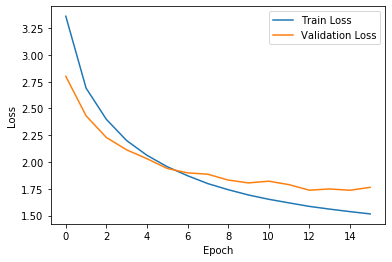

In [11]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
offset = 0
epoch_nums = [i for i in range(len(train_loss)+1)]
print(train_loss)
print(val_loss)
with open('train_loss_{offset}.csv', 'w+') as out:
    out.write('\n'.join(map(str,train_loss)))

with open('val_loss_{offset}.csv', 'w+') as out:
    out.write('\n'.join(map(str,val_loss)))
plt.figure()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend()
plt.show()

In [3]:
def sample():
    with torch.no_grad():
        input_tensor_chunk, _ = song_to_tensor_chunks(['<start>'], encoder, decoder)
        input_tensor = input_tensor_chunk[0].to(device)
        hidden = rnn.initHidden(device=device)
        prev_char_raw, hidden = rnn(input_tensor,hidden) 
        print(torch.argmax(prev_char_raw))
        prev_char_probs = torch.softmax(prev_char_raw, 2, prev_char_raw.dtype).view((n_chars))
        print(torch.argmax(prev_char_probs))
        output = '<start>'
        while True:
            selection = np.random.random()
            running_prob = 0
            for i, prob in enumerate(prev_char_probs):
                running_prob += prob
                if running_prob > selection:
                    print('i', i)
                    selected_char = decoder[i]
                    output += selected_char
                    input_tensor_chunk, _ = song_to_tensor_chunks([selected_char], encoder, decoder)
                    input_tensor = input_tensor_chunk[0].to(device)
                    break
            if selected_char == '<end>':
                break
            else:
                prev_char_raw, hidden = rnn(input_tensor,hidden) 
                prev_char_probs = torch.softmax(prev_char_raw, 2, prev_char_raw.dtype).view((n_chars))
        return output
print(sample())

NameError: name 'torch' is not defined

In [20]:
# Normal run 20 epochs
for i in range(6):
    print(sample())

<start>
X:150
T:Pau lady +Danatki
R:air
N:Alsoyr
D:Jone na Mfryar
R:Marss Btron
Z:Tanccrtsocheris.
S:Haulsion (1586)
Z:id:hn-jig-42
M:6/8
K:G
GAG BGE|EDD B2A|BAG ABd|ced dcA|D3 D2G|
BAA BBd|eAG gba|b2e dBc|BAG ~G3|1 Bc B2d:|2 ded d2d||
<end>
<start>
X:11
T:La cronnon
D:DEwain: Tumle Thew's Hottht Hom
R:(18
Z:Transcrit et/ou corrig? pa/ugioloub?hrie  Auveas Polland <dave@biff.org.uk>
M:2/4
L:1/8
K:A
b4|d2 e2|de A2|fe dd|d2 e2|d2 dc|A2 AB|c2 B2|A6|
c2 B2|A>B cc|d2 dB|B>A B2|F=B cg|
d2 dd/d/|dc B/e/d/c/|BA A3:|
<end>
<start>
X:20
T:Try's of th The Braueh Bonde's Browe & Bornagied Tumbendie
T:Tracque Croches5
Z:Sfeischeliton
O:France
A:Provence
C:?.
T:La leo dese ll anolie the Lito
Z:id:hn-hornpipe-31
M:C|
K:Cmax
dC||
FAG :G2AF FGAB|~A2A e2ee | fgfd dcde | fdea d2Bd |
g2fA ~D3A | dcBA GGBG | BcAB c2A2 :|
<end>
<start>
X:179
T:Prunlen gi er?si nome
O:1fled (166001118-14
Z:Transcrit et/ou corrig? par Michel BELLON - 2006-11-29
Z:Pour toute observation mailto:galouvielle@free.fr
M:2 Le san o


In [14]:
# hidden size 64 run 16 epochs
for i in range(6):
    print(sample())

<start>
X:60
T:Framdo dercioner's(
R:Scyledhe Heral S:C. (are.z.
R:Scolka Ginthe
Z:id:hn-polka-31
M:2/4
L:1/12
K:G
~G/e/ gG |
<end>
<start>
X:9
T:Lorow Roeutin, The
R:jig
L:1/8
O:Frave
C:hnDne-020
K:GB|
P:Finlendouto! d fff e2g | cdf d2 c3 | c>d cB c2 :| BF/B/c/B/ AB/e/ fe/f/f | f4 ga | e3 fc d dB Bdd/2 e/d/f/ gf e/d/d/e/ df ef gf f>f ed dc cA FF GA BBA AG | (G/c/B/d/ B/B/ BB |f/g/ eB g/e/c/e/ Bd/e/ ed gg | eg f>f fe | f>d ed de dd | de dc dB | de fe ee>f | g3 eb/c/ d/d>cB | B>G E>B A>B A| cd de ga f>e fe d>d g>e c | d2 gd/e/d/A/ GB cf B>d ce d>c>e ff>f f>d ff eg fg e>df G2 d>d | e2e fd/f/>d/2 g3 d>c A>Bc dc cB AB Bd c>ec | c/d/ d/e//e/d/A/ d>B AB BA | A2 AF BA F2 :|
<end>
<start>
X:15
T:Pour lourif's
N:Cialle
O:France
C:Trag.
E:Prougic.
C:La gfithor pary ig
Z:id:hn-march-31
M:2/4
L:1/8
H:Aristtion: O, 98L
D:wolliche -riesetalyu ttgan:
Z:A/argale
M:2/4
|:26
|: c/c/d/f/g/ d/B/ Bd df | ge/f/e/ d2 d | cd/c/ G2 B/2e/2 | B2z E>B/2G/ | E3/2G/4A/2 B3/4/2:| 
|:B2B/2 d/^2 dc/2c/2 :e2A2 GF AA>z 

In [1]:
print(sample)

NameError: name 'sample' is not defined